# 顧客推薦模型

## 一、載入套件

In [1]:
# Importing the libraries
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from util import get_dummies, detect_str_columns,model_testRF,results_summary_to_dataframe,plot_confusion_matrix,logistic_model,logistic_importance,logistic_conf

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, auc, accuracy_score,classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# ----設定繪圖-------
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import platform

In [2]:
# 讀取電商資料
data = pd.read_csv('contract.csv')

In [3]:
data.head()

,Prod_output_num,locations,gender,age,click_on_prod,balance,registry_to_use_time,credit_card_paid,active_member,estimated_salary,buy,UID
0,619,Taipei,Female,42,2,0.00,4,1,0,101348.88,1,0
1,608,Tainan,Female,41,1,83807.86,4,0,0,112542.58,0,1
2,502,Taipei,Female,42,8,159660.80,2,1,1,113931.57,1,2
3,699,Taipei,Female,39,1,0.00,3,0,1,93826.63,0,3
4,850,Tainan,Female,43,2,125510.82,4,1,0,79084.10,0,4


## 二、變數視覺化

不購買 79.63 % of the dataset
購買 20.37 % of the dataset


Text(0.5, 1.0, 'purchase decision \n (0:no vs 1:yes )')

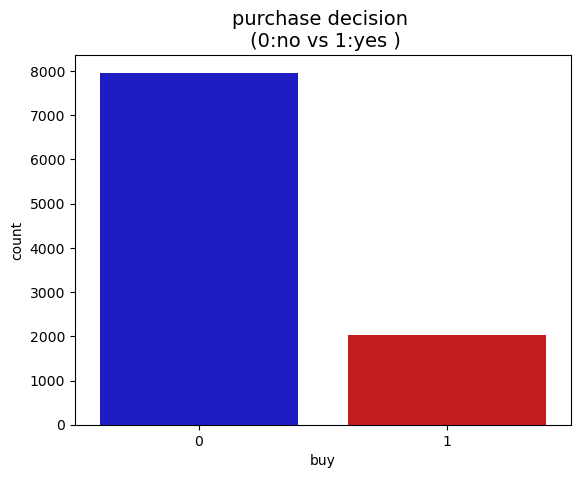

In [4]:
# Buy 比例
print('不購買', round(data['buy'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('購買', round(data['buy'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

# 看看 y變數的分佈圖
colors = ["#0101DF", "#DF0101"]
sns.countplot(x = 'buy', data =data, palette=colors)
plt.title('purchase decision \n (0:no vs 1:yes )', fontsize=14)

## 三、資料處理與轉換

 1. 標籤編碼（Label Encoding）：該方法將各類別轉換成數字，在商業界及社會科學中，
                                最常見的就是李克特5點量表的轉換，這也是「順序尺
                                度」之概念，也就是具有大小之分的類別，建議適用該
                                法。                            
 2. 獨熱編碼（One-Hot Encoding）：這代表將類別轉換成欄位格式，並且以1（有該類別）
                                與0（沒有該類別）的形式表示之。

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Prod_output_num       10000 non-null  int64  
 1   locations             10000 non-null  object 
 2   gender                10000 non-null  object 
 3   age                   10000 non-null  int64  
 4   click_on_prod         10000 non-null  int64  
 5   balance               10000 non-null  float64
 6   registry_to_use_time  10000 non-null  int64  
 7   credit_card_paid      10000 non-null  int64  
 8   active_member         10000 non-null  int64  
 9   estimated_salary      10000 non-null  float64
 10  buy                   10000 non-null  int64  
 11  UID                   10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [6]:
# 偵測有字串的欄位
str_columns = detect_str_columns(data)
print(str_columns)
'''
why?
因為['使用者地區', '性別']皆非順序尺度，當作一般one hot encoding類別變數處理就可
'''
# 自動化
dataset = get_dummies(str_columns, data)
dataset.head(5)

['locations', 'gender']


,Prod_output_num,age,click_on_prod,balance,registry_to_use_time,credit_card_paid,active_member,estimated_salary,buy,UID,locations_Taichung,locations_Tainan,locations_Taipei,gender_Female,gender_Male
0,619,42,2,0.00,4,1,0,101348.88,1,0,0,0,1,1,0
1,608,41,1,83807.86,4,0,0,112542.58,0,1,0,1,0,1,0
2,502,42,8,159660.80,2,1,1,113931.57,1,2,0,0,1,1,0
3,699,39,1,0.00,3,0,1,93826.63,0,3,0,0,1,1,0
4,850,43,2,125510.82,4,1,0,79084.10,0,4,0,1,0,1,0


### 四 、 資料處理與轉換

In [7]:
# 將X與y分割開來
X =dataset.drop(columns=['buy'])
y =dataset['buy']

In [8]:
# 切分資料集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [9]:
# X 訓練資料集維度
X_train.shape

(8000, 14)

In [10]:
# 保留UID ： 做推薦清單時需要將uid放回去 找到推薦人
train_uid = X_train['UID']
test_uid = X_test['UID']

In [11]:
# 刪除UID 流水號
# del 就是直接刪除，同drop(columns = '欄位')的效果
del X_train['UID']
#X_train['UID']
del X_test['UID']

In [12]:
# 訓練資料集的X 資料清理checklist
# 1. UID是否刪除
# 2. Dtype是否都是數值變數
# 3. y變數（buy）是否已經被移除
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 7389 to 2732
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Prod_output_num       8000 non-null   int64  
 1   age                   8000 non-null   int64  
 2   click_on_prod         8000 non-null   int64  
 3   balance               8000 non-null   float64
 4   registry_to_use_time  8000 non-null   int64  
 5   credit_card_paid      8000 non-null   int64  
 6   active_member         8000 non-null   int64  
 7   estimated_salary      8000 non-null   float64
 8   locations_Taichung    8000 non-null   uint8  
 9   locations_Tainan      8000 non-null   uint8  
 10  locations_Taipei      8000 non-null   uint8  
 11  gender_Female         8000 non-null   uint8  
 12  gender_Male           8000 non-null   uint8  
dtypes: float64(2), int64(6), uint8(5)
memory usage: 601.6 KB


## 五、模型選擇(一)：羅吉斯迴歸

### Model1：Logistic Regression

In [13]:
logistic_reg = LogisticRegression()

In [14]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_logistic = sc.fit_transform(X_train)
X_test_logistic = sc.transform(X_test)

In [15]:
# 進行訓練
logistic_reg.fit(X_train_logistic, y_train)

LogisticRegression()

In [16]:
# 預測
# 根據 >=0.5 購買機率來判斷是否為1，若 >=0.5 則為1，反之為 0
logistic_pred = logistic_reg.predict(X_test_logistic)
logistic_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [17]:
# 純粹計算購買機率
logistic_pred_proba = logistic_reg.predict_proba(X_test_logistic)
logistic_pred_proba

array([[0.79165244, 0.20834756],
       [0.65558126, 0.34441874],
       [0.85510249, 0.14489751],
       ...,
       [0.79897348, 0.20102652],
       [0.87423467, 0.12576533],
       [0.76669836, 0.23330164]])

In [18]:
# 準確率
accuracy_score(y_test, logistic_pred)

0.811

################ summary ################ 
[[1526   69]
 [ 309   96]]
Training Accuracy = 0.808
Test Accuracy = 0.811


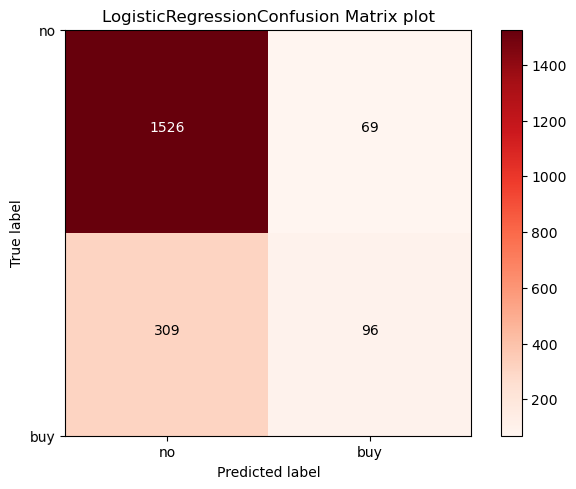

In [19]:
# Confusion matrix plot
# model_restRF 為 util.py 之自定義函式
model_testRF( LogisticRegression(),
            X_train_logistic,y_train,X_test_logistic,y_test, plot_name = 'LogisticRegression')

## 六、模型選擇(二)：隨機森林

In [20]:
# 模型定義
# verbose：秀訓練過程
# n_jobs:用多少cpu跑
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0,verbose=1,n_jobs=-1)

In [21]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_logistic = sc.fit_transform(X_train)
X_test_logistic = sc.transform(X_test)

In [22]:
rf_model.fit(X_train_logistic, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


RandomForestClassifier(n_jobs=-1, random_state=0, verbose=1)

In [23]:
rf_pred = rf_model.predict(X_test_logistic)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [24]:
# 預測機率
rf_pred_proba = rf_model.predict_proba(X_test_logistic)
rf_pred_proba

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


array([[0.65, 0.35],
       [0.77, 0.23],
       [0.77, 0.23],
       ...,
       [0.93, 0.07],
       [0.72, 0.28],
       [0.82, 0.18]])

In [25]:
# 準確率
accuracy_score(y_test, rf_pred)

0.868

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


################ summary ################ 
[[1528   67]
 [ 197  208]]
Training Accuracy = 1.000
Test Accuracy = 0.868


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


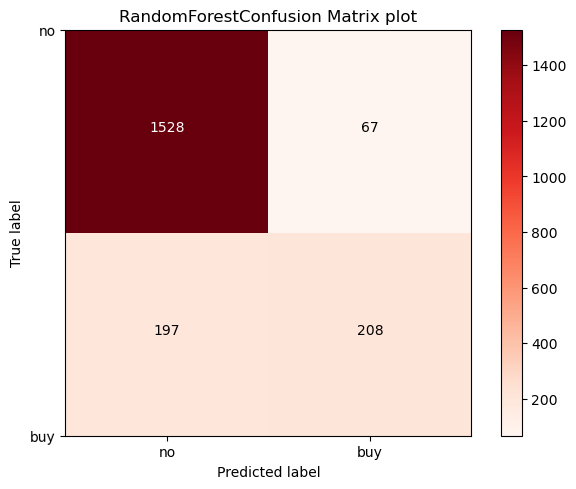

In [26]:
# 製作confusion matrix plot
model_testRF(RandomForestClassifier(n_estimators = 100, random_state = 0,verbose=1,n_jobs=8)    ,
            X_train_logistic,y_train,X_test_logistic,y_test, plot_name = 'RandomForest')

## 七、模型選擇(三)：XGBoost

learning_rate=0.5

In [27]:
# 定義模型
# nthread: 用多少顆cpu訓練
# learning_rate: 學習速率。
# 若高，運行速度快，學不精，預測效果通常差 0.5
# 若低，運行速度慢，學精，預測效果通常好 0.05
xgb_model = XGBClassifier(n_estimators=100 ,random_state = 0,
            nthread = 8, learning_rate=0.5)

In [28]:
# 訓練模型
# eval_set：每訓練完一次，就展現/驗證我的成果，但是不代表我訓練時候有碰eval_set
# 形式：[ (訓練X, 訓練y), (測試X, 測試y) ]
# eg. validation_0 --》 (訓練X, 訓練y)
# validation_1 --》 (測試X, 測試y)
# 會以validation_1為準
# error = 1 - 準確度；舉例：1 - 0.8 = 0.2，越低越好
xgb_model.fit(X_train, y_train, verbose=True,
            eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-logloss:0.47023	validation_1-logloss:0.47524
[1]	validation_0-logloss:0.38978	validation_1-logloss:0.39779
[2]	validation_0-logloss:0.35049	validation_1-logloss:0.36164
[3]	validation_0-logloss:0.32896	validation_1-logloss:0.34285
[4]	validation_0-logloss:0.31141	validation_1-logloss:0.33479
[5]	validation_0-logloss:0.30046	validation_1-logloss:0.33089
[6]	validation_0-logloss:0.29347	validation_1-logloss:0.32982
[7]	validation_0-logloss:0.28847	validation_1-logloss:0.32925
[8]	validation_0-logloss:0.28373	validation_1-logloss:0.33085
[9]	validation_0-logloss:0.28116	validation_1-logloss:0.33094
[10]	validation_0-logloss:0.27869	validation_1-logloss:0.33089
[11]	validation_0-logloss:0.27429	validation_1-logloss:0.33026
[12]	validation_0-logloss:0.27231	validation_1-logloss:0.33076
[13]	validation_0-logloss:0.26588	validation_1-logloss:0.33259
[14]	validation_0-logloss:0.26271	validation_1-logloss:0.33500
[15]	validation_0-logloss:0.25891	validation_1-logloss:0.33452
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, nthread=8, num_parallel_tree=None,
              predictor=None, ...)

In [29]:
# 定義模型，但是學習速率低，時間久，但準度會較高
# learning_rate請改0.05
xgb_model = XGBClassifier(n_estimators=100 ,random_state = 0,
            nthread = 8, learning_rate=0.05)

learning_rate=0.05

In [30]:
# 定義模型，但是學習速率低，時間久，但準度會較高
# learning_rate請改0.05
xgb_model = XGBClassifier(n_estimators=100 ,random_state = 0,
            nthread = 8, learning_rate=0.05)

In [31]:
# 訓練模型
xgb_model.fit(X_train, y_train, verbose=True,
                        eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-logloss:0.66454	validation_1-logloss:0.66520
[1]	validation_0-logloss:0.63864	validation_1-logloss:0.63987
[2]	validation_0-logloss:0.61512	validation_1-logloss:0.61668
[3]	validation_0-logloss:0.59370	validation_1-logloss:0.59571
[4]	validation_0-logloss:0.57404	validation_1-logloss:0.57663
[5]	validation_0-logloss:0.55611	validation_1-logloss:0.55907
[6]	validation_0-logloss:0.53958	validation_1-logloss:0.54281
[7]	validation_0-logloss:0.52440	validation_1-logloss:0.52808
[8]	validation_0-logloss:0.51040	validation_1-logloss:0.51437
[9]	validation_0-logloss:0.49737	validation_1-logloss:0.50188
[10]	validation_0-logloss:0.48541	validation_1-logloss:0.49023
[11]	validation_0-logloss:0.47431	validation_1-logloss:0.47935
[12]	validation_0-logloss:0.46372	validation_1-logloss:0.46908
[13]	validation_0-logloss:0.45409	validation_1-logloss:0.45978
[14]	validation_0-logloss:0.44505	validation_1-logloss:0.45121
[15]	validation_0-logloss:0.43655	validation_1-logloss:0.44317
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, nthread=8, num_parallel_tree=None,
              predictor=None, ...)

嘗試調整300顆樹，並將learning rate調整為0.01

In [32]:
# 定義模型：嘗試調整300顆樹，並將learning rate調整為0.01
# 【通常樹的增加與learning rate的減少會增益預測效果】
xgb_model = XGBClassifier(n_estimators=500 ,random_state = 0,
            nthread = 8, learning_rate=0.01)

In [33]:
# 開始執行訓練
xgb_model.fit(X_train, y_train, verbose=True,
                        eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-logloss:0.68731	validation_1-logloss:0.68744
[1]	validation_0-logloss:0.68159	validation_1-logloss:0.68186
[2]	validation_0-logloss:0.67598	validation_1-logloss:0.67638
[3]	validation_0-logloss:0.67048	validation_1-logloss:0.67102
[4]	validation_0-logloss:0.66508	validation_1-logloss:0.66576
[5]	validation_0-logloss:0.65979	validation_1-logloss:0.66058
[6]	validation_0-logloss:0.65460	validation_1-logloss:0.65552
[7]	validation_0-logloss:0.64951	validation_1-logloss:0.65051
[8]	validation_0-logloss:0.64451	validation_1-logloss:0.64562
[9]	validation_0-logloss:0.63960	validation_1-logloss:0.64081
[10]	validation_0-logloss:0.63479	validation_1-logloss:0.63609
[11]	validation_0-logloss:0.63007	validation_1-logloss:0.63146
[12]	validation_0-logloss:0.62543	validation_1-logloss:0.62692
[13]	validation_0-logloss:0.62088	validation_1-logloss:0.62243
[14]	validation_0-logloss:0.61640	validation_1-logloss:0.61806
[15]	validation_0-logloss:0.61201	validation_1-logloss:0.61373
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, nthread=8, num_parallel_tree=None,
              predictor=None, ...)

In [34]:
# 預測
xgb_pred = xgb_model.predict(X_test)

In [35]:
# 預測機率
xgb_pred_proba = xgb_model.predict_proba(X_test)

In [36]:
# 準確率
accuracy_score(y_test, xgb_pred)

0.871

## 八、製作顧客產品推薦名單

In [37]:
# 已經驗證過的資料
y_test

9394    0
898     1
2398    0
5906    0
2343    0
       ..
1037    0
2899    0
9549    0
2740    0
6690    0
Name: buy, Length: 2000, dtype: int64

In [38]:
XGBClassifier_test_df=pd.DataFrame(y_test.values ,columns =['客戶對A商品【實際】購買狀態'])
XGBClassifier_test_df.head()

,客戶對A商品【實際】購買狀態
0,0
1,1
2,0
3,0
4,0


In [39]:
# 預測購買機率
xgb_pred_proba

array([[0.6254863 , 0.3745137 ],
       [0.7831879 , 0.21681206],
       [0.842691  , 0.15730901],
       ...,
       [0.91584694, 0.08415303],
       [0.80696   , 0.19304001],
       [0.7875271 , 0.21247289]], dtype=float32)

In [40]:
# 先檢視一下預測出來的顧客清單，發現，我們要抓第一個欄位，即預測會購買的欄位機率
# [:, 1]：抓全部的row與抓第一欄（算頭，我的頭是1，尾無）
# 在array裡面，我們可以直接省略iloc
# 在array或pandas裡面， df[ row,  column]
xgb_pred_proba[ :  , 1]

array([0.3745137 , 0.21681206, 0.15730901, ..., 0.08415303, 0.19304001,
       0.21247289], dtype=float32)

In [41]:
XGBClassifier_test_df['客戶對A商品【預測】購買機率'] = xgb_pred_proba[:,1]
XGBClassifier_test_df.head()

,客戶對A商品【實際】購買狀態,客戶對A商品【預測】購買機率
0,0,0.374514
1,1,0.216812
2,0,0.157309
3,0,0.067028
4,0,0.067427


In [42]:
# 看一下我們的test_uid（測試資料集的uid）
test_uid

9394    9394
898      898
2398    2398
5906    5906
2343    2343
        ... 
1037    1037
2899    2899
9549    9549
2740    2740
6690    6690
Name: UID, Length: 2000, dtype: int64

In [43]:
# 將流水號（index）與顧客清單（XGBClassifier_test_df）的流水號一致才可以合併正確
# reset_index：將流水號重新編碼，會將流水號獨立出來一個新的欄位
# drop(columns = ['index']) ：將【流水號獨立出來一個新的欄位】給刪掉
# Q：看似有兩個index，但是最左邊的index會不算在欄位的範圍，知道reset_index後，才會有index在欄位裡面
test_uid = test_uid.reset_index()
test_uid

,index,UID
0,9394,9394
1,898,898
2,2398,2398
3,5906,5906
4,2343,2343
...,...,...
1995,1037,1037
1996,2899,2899
1997,9549,9549
1998,2740,2740


In [44]:
# 將index去除
test_uid = test_uid.drop(columns = ['index'])
test_uid

,UID
0,9394
1,898
2,2398
3,5906
4,2343
...,...
1995,1037
1996,2899
1997,9549
1998,2740


將test_uid與XGBClassifier_test_df結合成2欄

In [45]:
XGBClassifier_test_df = pd.concat([test_uid, XGBClassifier_test_df  ], axis = 1)
XGBClassifier_test_df

,UID,客戶對A商品【實際】購買狀態,客戶對A商品【預測】購買機率
0,9394,0,0.374514
1,898,1,0.216812
2,2398,0,0.157309
3,5906,0,0.067028
4,2343,0,0.067427
...,...,...,...
1995,1037,0,0.027477
1996,2899,0,0.051384
1997,9549,0,0.084153
1998,2740,0,0.193040


In [46]:
XGBClassifier_test_df = XGBClassifier_test_df.sort_values('客戶對A商品【預測】購買機率', ascending=False)
XGBClassifier_test_df

,UID,客戶對A商品【實際】購買狀態,客戶對A商品【預測】購買機率
733,5922,1,0.981281
1335,237,1,0.981216
323,7457,1,0.979898
1430,2154,1,0.979530
1357,4563,1,0.977599
...,...,...,...
337,2585,0,0.010535
192,9862,0,0.010484
1239,9752,0,0.010370
805,2250,0,0.010152


In [47]:
XGBClassifier_test_df.to_csv('顧客產品推薦名單.csv', encoding='utf-8-sig')

In [48]:
# 用 util.py 之自定義函式重新 run 一次
from util import client_list
client_list(model = xgb_model,y_test=y_test, X_test=X_test, test_uid=test_uid, name = 'test')

,UID,客戶對A商品【實際】購買狀態,客戶對A商品【預測】購買機率
733,5922,1,0.981281
1335,237,1,0.981216
323,7457,1,0.979898
1430,2154,1,0.979530
1357,4563,1,0.977599
...,...,...,...
337,2585,0,0.010535
192,9862,0,0.010484
1239,9752,0,0.010370
805,2250,0,0.010152


## 九、儲存model

In [49]:
import pickle

In [50]:
# 商業意涵
# 1. 不用再次訓練本模型，僅需要再次載入及預測新資料即可
# 2. 可以做合作夥伴第二次生意，保密模型的訓練過程
pickle.dump(xgb_model, open("xgb_model.dat", "wb"))  #wb : write binary (寫入成二元檔案)


In [51]:
# 未來直接 load 模型即可使用
model_xgb = pickle.load(open("xgb_model.dat", "rb")) # read binary
model_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, nthread=8, num_parallel_tree=None,
              predictor=None, ...)